In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import xgboost as xgboost

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Regression result plot

In coutersy of Avocado price prediction <a href='https://www.kaggle.com/adamwro/avocado-price-prediction/notebook'>Avocado price prediction</a>

In [24]:
def regression_results(y_true_a, y_pred_a):
    # Regression metrics
    l_mean_absolute_error=mean_absolute_error(y_true_a, y_pred_a)
    l_mean_squared=mean_squared_error(y_true_a, y_pred_a)
    l_r2=r2_score(y_true_a, y_pred_a)

    print('r2: ', round(l_r2,4))
    print('MAE: ', round(l_mean_absolute_error,4))
    print('MSE: ', round(l_mean_squared,4))
    
def result_plot(y_test_b, y_pred_b, name):
    plt.figure(figsize=(40,10))
    plt.plot(y_pred_b, 'ro', label='prediction')
    plt.plot(y_test_b,' go', label='ground truth')
    plt.legend(loc='upper right')
    plt.show()
    print(f'\n {name}:')
    regression_results(y_test_b, y_pred_b)
    
    matplotlib.rc('xtick', labelsize=15)
    matplotlib.rc('ytick', labelsize=15)

    fig, ax = plt.subplots(figsize=(10, 10))

    plt.style.use('ggplot')
    plt.plot(y_pred_b, y_test_b, 'ro')
    plt.xlabel('Predictions', fontsize = 15)
    plt.ylabel('Ground truth', fontsize = 15)
    plt.title('{}: Predictions vs Ground truth on dataset'.format(name), fontsize = 15)
    # ax.plot([y_pred_b.min(), y_pred_b.max()], [y_test_b.min(), y_test_b.max()], 'k--')
    ax.plot([0, 3], [0, 3], 'k--')
    plt.show()

def plot_residual_distribution(y_predicted, y_test, name):
    sns.displot(np.abs((y_predicted-y_test)))
    plt.title('{}: Residual distribution on test set'.format(name))

# Approach 1: TimeSeries approach groupby sales date -> merge with google data
(Assumption: Avocado King wants to see sale price per day )

## Load sales dataset

In [25]:
# Load dataset, groupby date and keep date, price, volume sales only
price_df = pd.read_csv('Data/price-and-sales-data.csv')

price_df = price_df[['Date', 'TotalVolume', '4046', '4225', '4770', 'AveragePrice']]
price_df.head()

,Date,TotalVolume,4046,4225,4770,AveragePrice
0,2015-01-04,40873.28,2819.50,28287.42,49.90,1.22
1,2015-01-04,435021.49,364302.39,23821.16,82.15,1.00
2,2015-01-04,788025.06,53987.31,552906.04,39995.03,NaN
3,2015-01-04,80034.32,44562.12,24964.23,2752.35,1.01
4,2015-01-04,491738.00,7193.87,396752.18,128.82,1.02


In [26]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25161 entries, 0 to 25160
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          25161 non-null  object 
 1   TotalVolume   24212 non-null  float64
 2   4046          24261 non-null  float64
 3   4225          24255 non-null  float64
 4   4770          24245 non-null  float64
 5   AveragePrice  24259 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.2+ MB


In [27]:
price_df.isna().sum()

Date              0
TotalVolume     949
4046            900
4225            906
4770            916
AveragePrice    902
dtype: int64

## Handle missing values with mean of that date
(one practice since only numeric columns selected)

In [28]:
# keep column names with missing values
checking_missing_values = price_df.isnull().any()
missing_value_cols = checking_missing_values[checking_missing_values == True].index.values
print(missing_value_cols)
for col in missing_value_cols:
    if price_df[col].dtypes != 'object': # double check dtype is NOT object (categorical)
        price_df[col] = price_df.groupby('Date')[col].transform(lambda x : x.fillna(x.mean()))
price_df.isnull().sum()

['TotalVolume' '4046' '4225' '4770' 'AveragePrice']


Date            0
TotalVolume     0
4046            0
4225            0
4770            0
AveragePrice    0
dtype: int64

In [29]:
price_df['Date'] = pd.to_datetime(price_df['Date'])

## Group by date

In [30]:
weekly_sales = price_df.groupby('Date').mean()

In [31]:
weekly_sales.head(20)

,TotalVolume,4046,4225,4770,AveragePrice
Date,,,,,
2015-01-04,8.099662e+05,304596.562243,340660.346792,22114.101961,1.307835
2015-01-11,6.689602e+05,299851.904078,287881.821415,22233.286571,1.368208
2015-01-18,7.361360e+05,311621.951176,287541.832200,19767.117692,1.387429
2015-01-25,7.023153e+05,266170.388835,286200.404600,19607.347736,1.392913
2015-02-01,1.154487e+06,481927.676990,480036.740777,35116.136857,1.251792
2015-02-08,8.369908e+05,343926.558922,349566.629327,18610.007451,1.307767
2015-02-15,7.279368e+05,307217.689505,247157.866190,21833.235049,1.399600
2015-02-22,4.899634e+05,326173.044327,296920.056634,19847.057129,1.349412
2015-03-01,8.230888e+05,315043.677282,370374.643838,27933.385980,1.312451


<AxesSubplot:xlabel='Date'>

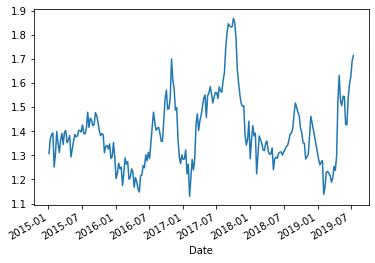

In [32]:
weekly_sales['AveragePrice'].plot()

In [33]:
weekly_sales.reset_index(inplace=True)

In [34]:
google_data = pd.read_csv('Data/google-data.csv')
google_data['Week'] = pd.to_datetime(google_data['Week'])
google_data.head(20)

,Week,avocado: (United States),organic: (United States),avocado recipe: (United States),avocado toast: (United States),avocado sandwich: (United States),organic avocado: (United States)
0,2015-01-04,46,76,84,8,51,10
1,2015-01-11,48,79,76,8,38,29
2,2015-01-18,48,82,84,9,66,27
3,2015-01-25,49,82,89,8,44,28
4,2015-02-01,52,81,82,7,46,42
5,2015-02-08,41,80,67,8,60,40
6,2015-02-15,40,80,61,7,48,17
7,2015-02-22,41,82,55,8,50,23
8,2015-03-01,44,83,72,9,38,26
9,2015-03-08,41,80,66,7,47,31


## Merge with Google data

In [35]:
combined_df = pd.merge(weekly_sales, google_data, how='outer', left_on='Date', right_on='Week')
combined_df.head(20)

,Date,TotalVolume,4046,4225,4770,AveragePrice,Week,avocado: (United States),organic: (United States),avocado recipe: (United States),avocado toast: (United States),avocado sandwich: (United States),organic avocado: (United States)
0,2015-01-04,8.099662e+05,304596.562243,340660.346792,22114.101961,1.307835,2015-01-04,46.0,76.0,84.0,8.0,51.0,10.0
1,2015-01-11,6.689602e+05,299851.904078,287881.821415,22233.286571,1.368208,2015-01-11,48.0,79.0,76.0,8.0,38.0,29.0
2,2015-01-18,7.361360e+05,311621.951176,287541.832200,19767.117692,1.387429,2015-01-18,48.0,82.0,84.0,9.0,66.0,27.0
3,2015-01-25,7.023153e+05,266170.388835,286200.404600,19607.347736,1.392913,2015-01-25,49.0,82.0,89.0,8.0,44.0,28.0
4,2015-02-01,1.154487e+06,481927.676990,480036.740777,35116.136857,1.251792,2015-02-01,52.0,81.0,82.0,7.0,46.0,42.0
5,2015-02-08,8.369908e+05,343926.558922,349566.629327,18610.007451,1.307767,2015-02-08,41.0,80.0,67.0,8.0,60.0,40.0
6,2015-02-15,7.279368e+05,307217.689505,247157.866190,21833.235049,1.399600,2015-02-15,40.0,80.0,61.0,7.0,48.0,17.0
7,2015-02-22,4.899634e+05,326173.044327,296920.056634,19847.057129,1.349412,2015-02-22,41.0,82.0,55.0,8.0,50.0,23.0
8,2015-03-01,8.230888e+05,315043.677282,370374.643838,27933.385980,1.312451,2015-03-01,44.0,83.0,72.0,9.0,38.0,26.0
9,2015-03-08,7.266006e+05,329290.794020,265713.112475,21440.589135,1.365149,2015-03-08,41.0,80.0,66.0,7.0,47.0,31.0


## Reason missing values with merged data

In [36]:
combined_df.isnull().sum()

Date                                 7
TotalVolume                          7
4046                                 7
4225                                 7
4770                                 7
AveragePrice                         7
Week                                 1
avocado: (United States)             1
organic: (United States)             1
avocado recipe: (United States)      1
avocado toast: (United States)       1
avocado sandwich: (United States)    1
organic avocado: (United States)     1
dtype: int64

In [37]:
combined_df[combined_df.isnull().any(axis=1)]

,Date,TotalVolume,4046,4225,4770,AveragePrice,Week,avocado: (United States),organic: (United States),avocado recipe: (United States),avocado toast: (United States),avocado sandwich: (United States),organic avocado: (United States)
205,2019-01-07,1.137379e+06,348652.532407,303622.763148,21984.832222,1.281111,NaT,NaN,NaN,NaN,NaN,NaN,NaN
233,NaT,NaN,NaN,NaN,NaN,NaN,2018-12-09,43.0,81.0,50.0,35.0,44.0,34.0
234,NaT,NaN,NaN,NaN,NaN,NaN,2018-12-16,43.0,73.0,60.0,37.0,34.0,12.0
235,NaT,NaN,NaN,NaN,NaN,NaN,2018-12-23,50.0,63.0,55.0,42.0,27.0,56.0
236,NaT,NaN,NaN,NaN,NaN,NaN,2018-12-30,63.0,74.0,81.0,64.0,54.0,43.0
237,NaT,NaN,NaN,NaN,NaN,NaN,2019-01-06,73.0,85.0,88.0,68.0,61.0,67.0
238,NaT,NaN,NaN,NaN,NaN,NaN,2019-07-21,60.0,74.0,68.0,56.0,54.0,49.0
239,NaT,NaN,NaN,NaN,NaN,NaN,2019-07-28,66.0,74.0,79.0,55.0,46.0,36.0


In [38]:
combined_df.dropna(inplace=True)

## Feature selection based on correlation

<AxesSubplot:>

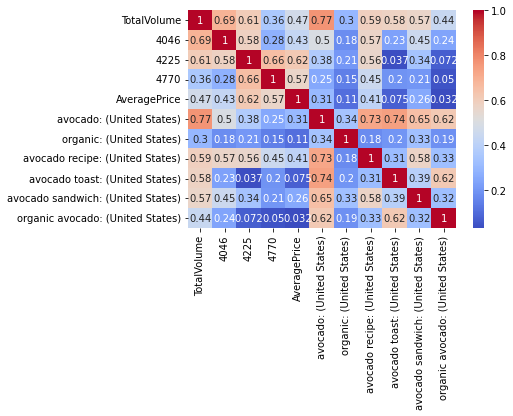

In [39]:
import numpy as np
sns.heatmap(np.abs(combined_df.corr()),annot=True, cmap='coolwarm')

In [40]:
a = np.abs(combined_df.corr())['AveragePrice'] > 0.3
column_df = pd.DataFrame(a)
keep_cols = list(column_df[column_df.AveragePrice==True].index.values)
keep_cols

['TotalVolume',
 '4046',
 '4225',
 '4770',
 'AveragePrice',
 'avocado: (United States)',
 'avocado recipe: (United States)']

## Modelling

### Train test split

In [41]:
def train_test_split_timeseries(input_df, test_start=2019, index_col='Week', output_col='AveragePrice', keep_cols=None, min_max_scaler=True):    
    set_df = input_df.set_index(index_col)
    if keep_cols:
        set_df = set_df[keep_cols]

    X = set_df.drop([output_col, 'Date'], axis=1)
    y = set_df[output_col]

    X_train = X[:str(test_start-1)]
    y_train = y[:str(test_start-1)]
    y_test = y[str(test_start):]
    X_test = X[str(test_start):]

    if min_max_scaler:
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_timeseries(combined_df, test_start=2017)

### Linear Regression model

mae score 0.15423616894916659


Text(0.5, 1.0, 'Regression: Ground truth and prediction')

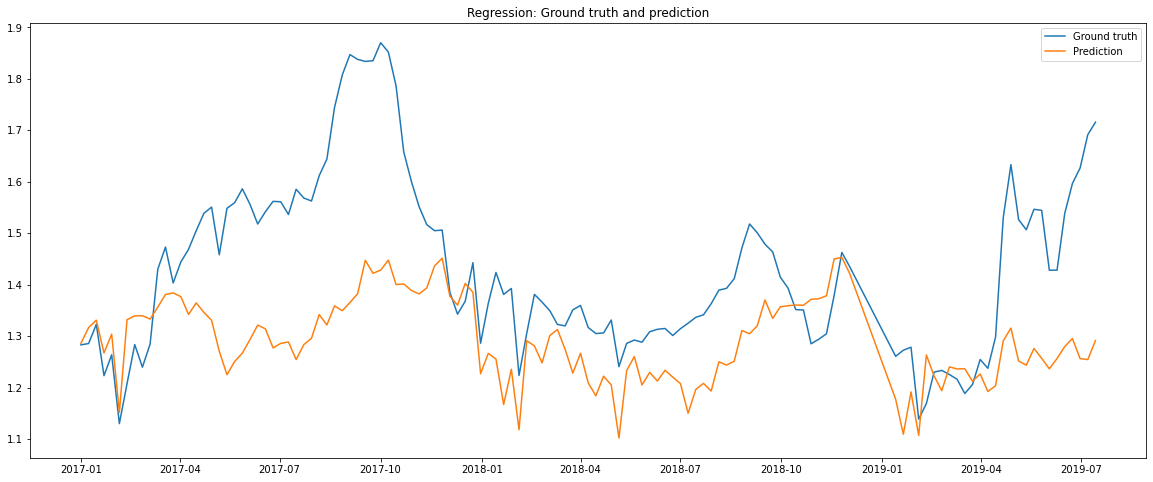

In [42]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_predicted = lr.predict(X_test)
print('mae score', mean_absolute_error(y_predicted, y_test.values))

# Map back prediction to time-series test data and plot
y_predicted_df = pd.DataFrame(y_predicted)
y_predicted_df.index = y_test.index
plt.figure(figsize=(20,8))
plt.plot(y_test, label='Ground truth')
plt.plot(y_predicted_df, label='Prediction')
plt.legend()
plt.title('Regression: Ground truth and prediction')

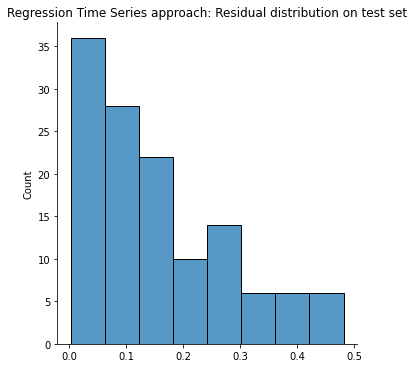

In [43]:
plot_residual_distribution(y_test.values, y_predicted, 'Regression Time Series approach')

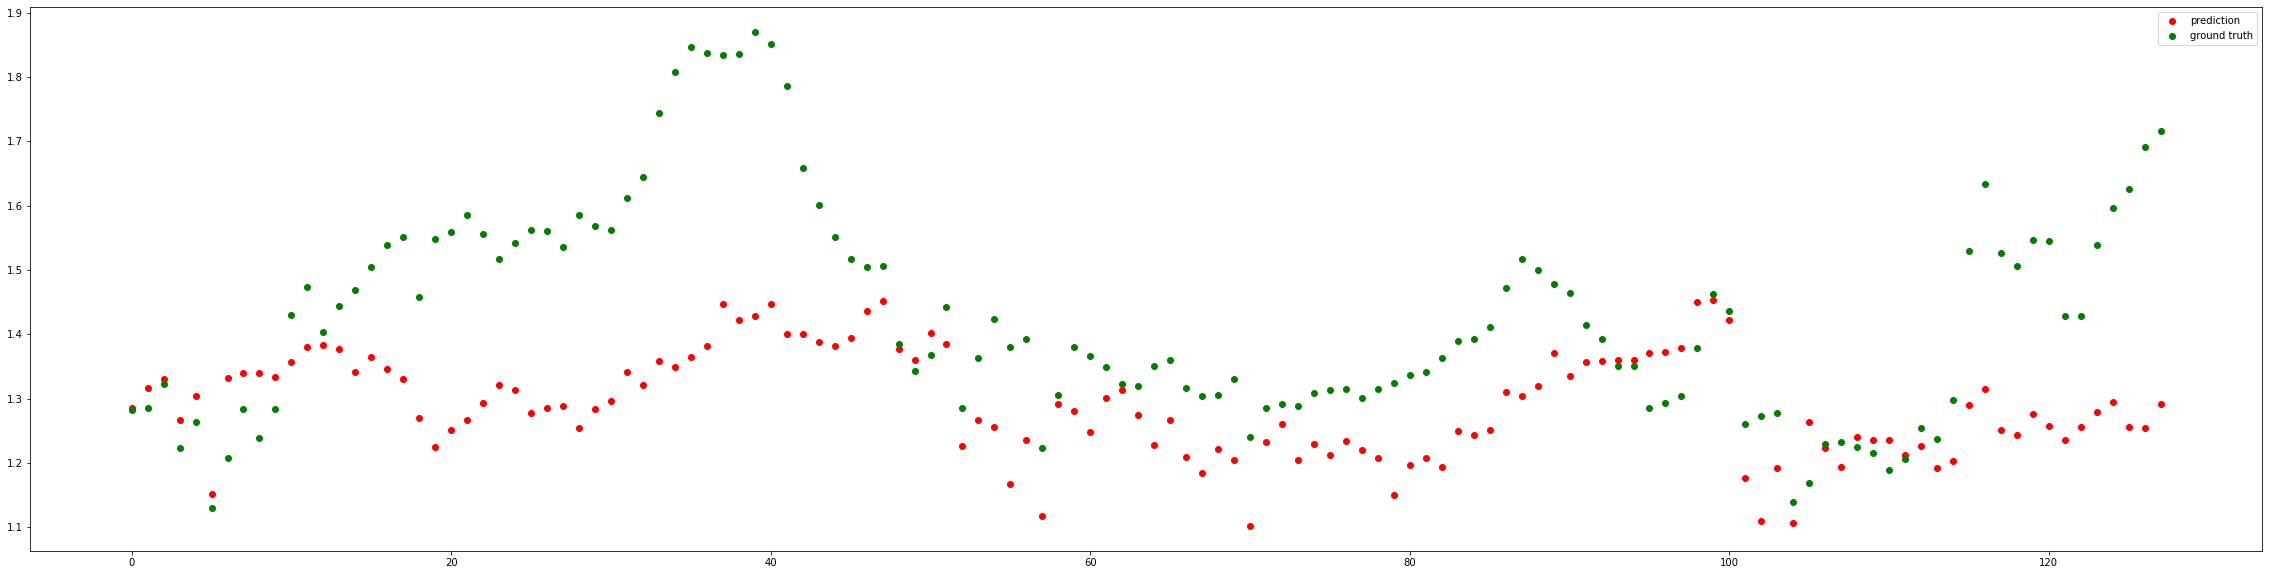


 Regression Time Series approach:
r2:  -0.395
MAE:  0.1542
MSE:  0.039


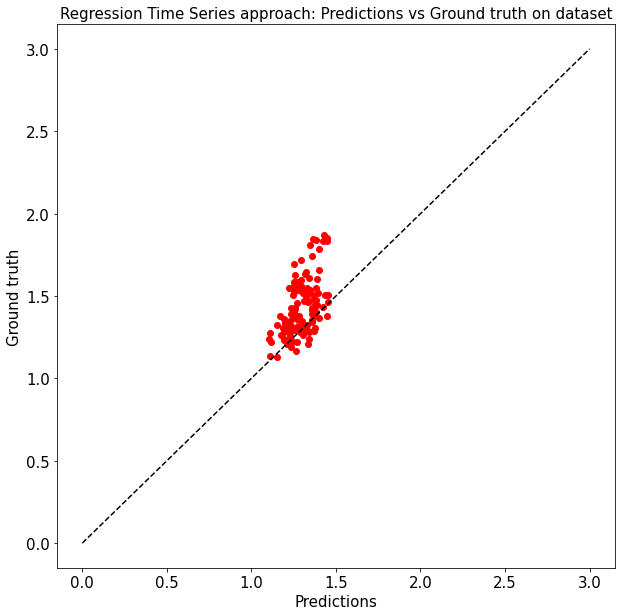

In [44]:
result_plot(y_test.values, y_predicted, 'Regression Time Series approach')

### Ridge modelling

mae 0.15421397819886565
mae 0.15402045336495318
mae 0.15258068840004543
mae 0.1524105854117095
mae 0.15576322274105614
mae 0.13660635585312014


Text(0.5, 0.98, 'Ridge models: ground truth and prediction')

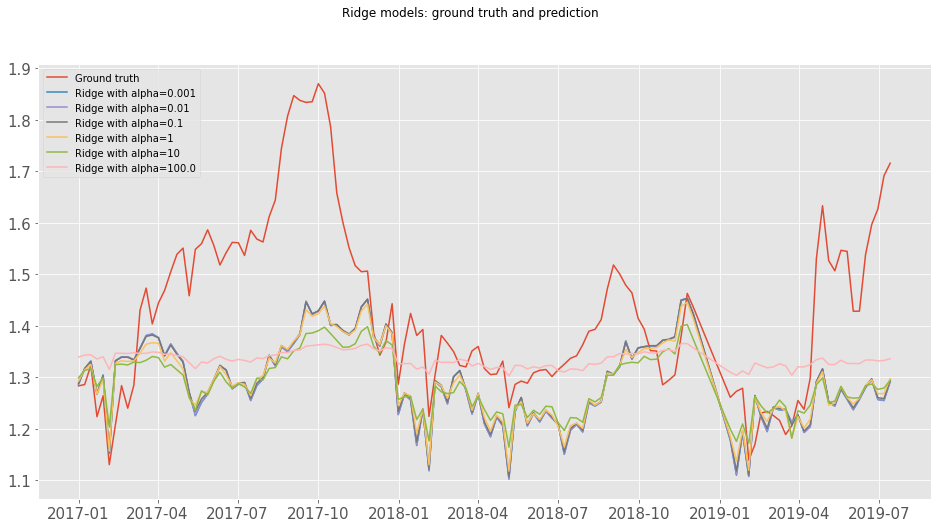

In [45]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
alphas = [1e-3, 1e-2, .1, 1, 10, 1e2]
plt.figure(figsize=(16,8))
plt.plot(y_test)
labels = ['Ground truth']
for (ii, alpha) in enumerate(alphas):
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    # Map back prediction to time-series test data and plot
    y_predicted_df = pd.DataFrame(y_predicted)
    y_predicted_df.index = y_test.index
    print('mae', mean_absolute_error(y_test.values, y_predicted))
    plt.plot(y_predicted_df)
    labels.append('Ridge with alpha='+str(alpha))
    

plt.legend(labels)
plt.suptitle('Ridge models: ground truth and prediction')

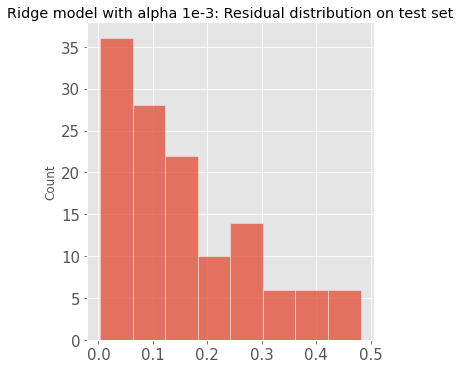

In [46]:
model = Ridge(alpha=1e-3)
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
plot_residual_distribution(y_predicted, y_test.values, 'Ridge model with alpha 1e-3')

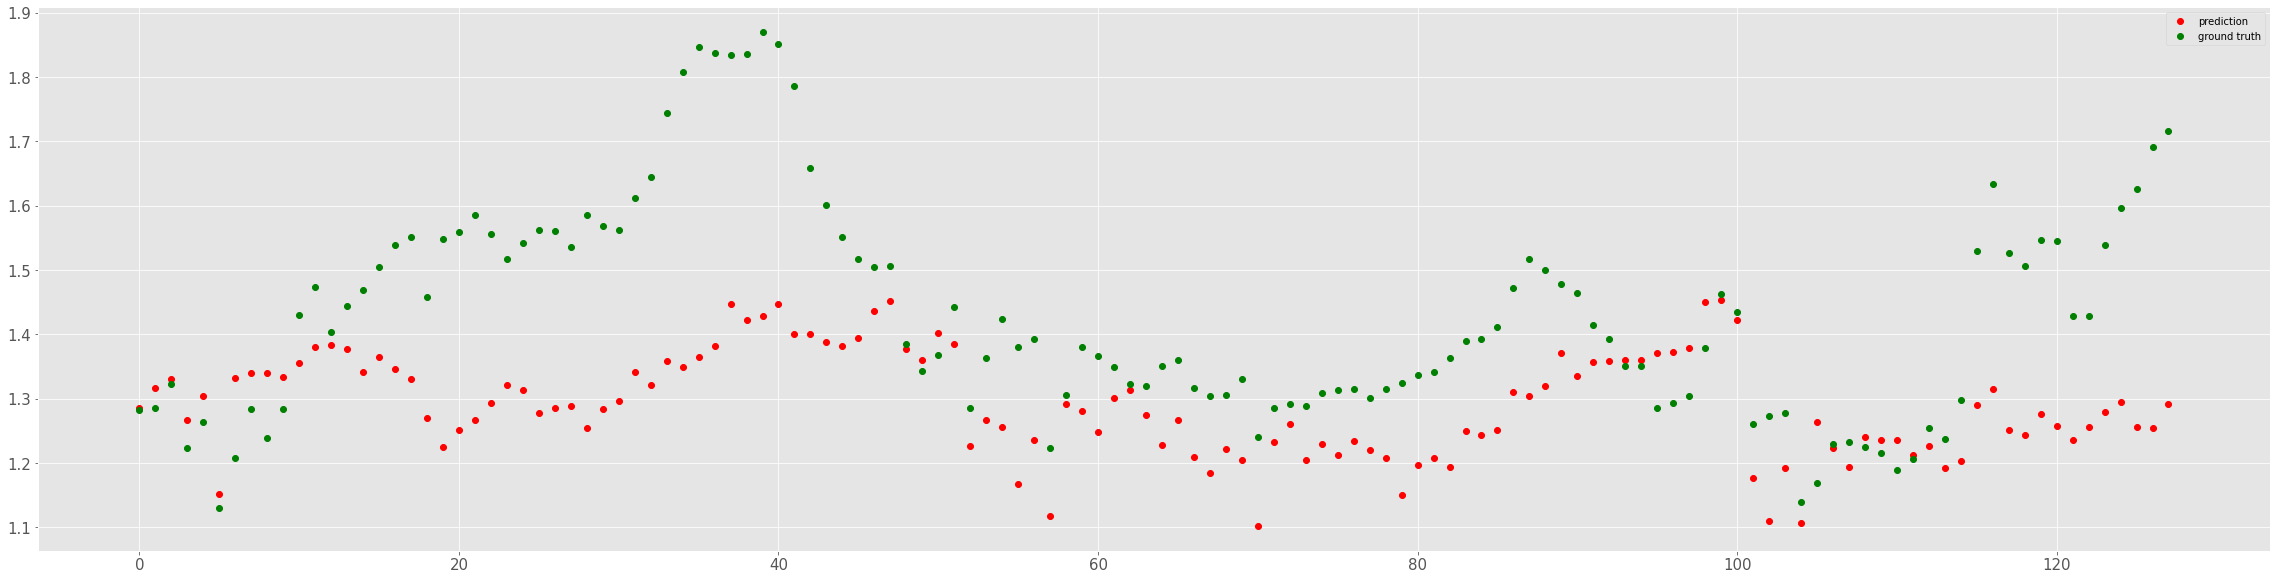


 Ridge - Timeseries approach:
r2:  -0.3947
MAE:  0.1542
MSE:  0.039


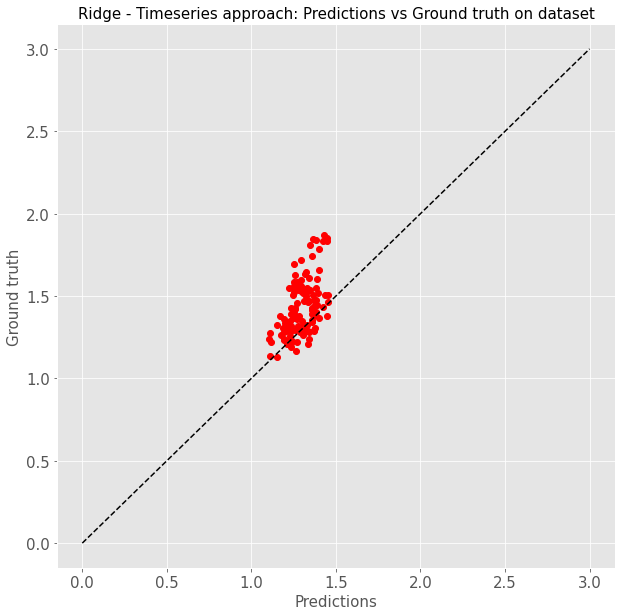

In [47]:
result_plot(y_test.values, y_predicted, 'Ridge - Timeseries approach')

### Conclusion
Good for recognising the trend but not really predict the exact price. Be careful to input great incidence into the model

# Approach 2: Tabular approach

In [48]:
price_df = pd.read_csv('Data/price-and-sales-data.csv')
price_df.head(100)

,Date,AveragePrice,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
2,2015-01-04,NaN,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,BaltimoreWashington
3,2015-01-04,1.01,80034.32,44562.12,24964.23,2752.35,7755.62,6064.30,1691.32,0.0,conventional,2015,Boise
4,2015-01-04,1.02,491738.00,7193.87,396752.18,128.82,87663.13,87406.84,256.29,0.0,conventional,2015,Boston
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2015-01-04,1.23,19089.36,17522.46,735.22,2.87,828.81,828.81,0.00,0.0,organic,2015,SanDiego
96,2015-01-04,1.18,22630.58,13175.57,9028.34,0.00,426.67,426.67,0.00,0.0,organic,2015,SanFrancisco
97,2015-01-04,1.49,33795.91,6821.76,20720.77,NaN,6252.15,452.73,5799.42,0.0,organic,2015,Seattle
98,2015-01-04,1.86,3351.76,355.79,754.78,439.19,1802.00,1768.67,NaN,0.0,organic,2015,SouthCarolina


## Preprocessing

### Filling missing values with mean of that date

In [49]:
# keep column names with missing values
checking_missing_values = price_df.isnull().any()
missing_value_cols = checking_missing_values[checking_missing_values == True].index.values
print(missing_value_cols)
for col in missing_value_cols:
    if price_df[col].dtypes != 'object': # double check dtype is NOT object (categorical)
        price_df[col] = price_df.groupby('Date')[col].transform(lambda x : x.fillna(x.mean()))
price_df.isnull().sum()

['AveragePrice' 'TotalVolume' '4046' '4225' '4770' 'TotalBags' 'SmallBags'
 'LargeBags' 'XLargeBags']


Date            0
AveragePrice    0
TotalVolume     0
4046            0
4225            0
4770            0
TotalBags       0
SmallBags       0
LargeBags       0
XLargeBags      0
type            0
year            0
region          0
dtype: int64

In [50]:
print(price_df.describe())
print(price_df.info())

       AveragePrice   TotalVolume          4046          4225          4770  \
count  25161.000000  2.516100e+04  2.516100e+04  2.516100e+04  2.516100e+04   
mean       1.396003  9.148542e+05  2.979322e+05  2.957121e+05  2.247366e+04   
std        0.378586  3.661058e+06  1.265392e+06  1.187539e+06  1.027607e+05   
min        0.440000  8.456000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
25%        1.120000  1.400096e+04  9.223600e+02  3.284480e+03  0.000000e+00   
50%        1.360000  1.363315e+05  1.225826e+04  3.093655e+04  2.520000e+02   
75%        1.630000  5.593169e+05  1.356466e+05  1.881154e+05  7.958550e+03   
max        3.250000  6.371614e+07  2.274362e+07  2.047057e+07  2.546439e+06   

          TotalBags     SmallBags     LargeBags     XLargeBags          year  
count  2.516100e+04  2.516100e+04  2.516100e+04   25161.000000  25161.000000  
mean   2.932332e+05  2.110326e+05  7.511472e+04    4361.059074   2016.776877  
std    1.211114e+06  8.531225e+05  3.518528e+05   2

### Merge with Google data

In [51]:
google_data = pd.read_csv('Data/google-data.csv')
google_data.head(10)

,Week,avocado: (United States),organic: (United States),avocado recipe: (United States),avocado toast: (United States),avocado sandwich: (United States),organic avocado: (United States)
0,2015-01-04,46,76,84,8,51,10
1,2015-01-11,48,79,76,8,38,29
2,2015-01-18,48,82,84,9,66,27
3,2015-01-25,49,82,89,8,44,28
4,2015-02-01,52,81,82,7,46,42
5,2015-02-08,41,80,67,8,60,40
6,2015-02-15,40,80,61,7,48,17
7,2015-02-22,41,82,55,8,50,23
8,2015-03-01,44,83,72,9,38,26
9,2015-03-08,41,80,66,7,47,31


In [52]:
combined_df = pd.merge(price_df, google_data, how='inner', left_on='Date', right_on='Week')
combined_df.head(100)

,Date,AveragePrice,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region,Week,avocado: (United States),organic: (United States),avocado recipe: (United States),avocado toast: (United States),avocado sandwich: (United States),organic avocado: (United States)
0,2015-01-04,1.220000,40873.28,2819.50,28287.42,49.900000,9716.46,9186.93,529.530000,0.0,conventional,2015,Albany,2015-01-04,46,76,84,8,51,10
1,2015-01-04,1.000000,435021.49,364302.39,23821.16,82.150000,46815.79,16707.15,30108.640000,0.0,conventional,2015,Atlanta,2015-01-04,46,76,84,8,51,10
2,2015-01-04,1.307835,788025.06,53987.31,552906.04,39995.030000,141136.68,137146.07,3990.610000,0.0,conventional,2015,BaltimoreWashington,2015-01-04,46,76,84,8,51,10
3,2015-01-04,1.010000,80034.32,44562.12,24964.23,2752.350000,7755.62,6064.30,1691.320000,0.0,conventional,2015,Boise,2015-01-04,46,76,84,8,51,10
4,2015-01-04,1.020000,491738.00,7193.87,396752.18,128.820000,87663.13,87406.84,256.290000,0.0,conventional,2015,Boston,2015-01-04,46,76,84,8,51,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2015-01-04,1.230000,19089.36,17522.46,735.22,2.870000,828.81,828.81,0.000000,0.0,organic,2015,SanDiego,2015-01-04,46,76,84,8,51,10
96,2015-01-04,1.180000,22630.58,13175.57,9028.34,0.000000,426.67,426.67,0.000000,0.0,organic,2015,SanFrancisco,2015-01-04,46,76,84,8,51,10
97,2015-01-04,1.490000,33795.91,6821.76,20720.77,22114.101961,6252.15,452.73,5799.420000,0.0,organic,2015,Seattle,2015-01-04,46,76,84,8,51,10
98,2015-01-04,1.860000,3351.76,355.79,754.78,439.190000,1802.00,1768.67,24117.389216,0.0,organic,2015,SouthCarolina,2015-01-04,46,76,84,8,51,10


In [53]:
combined_df.isnull().sum()

Date                                 0
AveragePrice                         0
TotalVolume                          0
4046                                 0
4225                                 0
4770                                 0
TotalBags                            0
SmallBags                            0
LargeBags                            0
XLargeBags                           0
type                                 0
year                                 0
region                               0
Week                                 0
avocado: (United States)             0
organic: (United States)             0
avocado recipe: (United States)      0
avocado toast: (United States)       0
avocado sandwich: (United States)    0
organic avocado: (United States)     0
dtype: int64

### Correlation analysis of combined data

<AxesSubplot:>

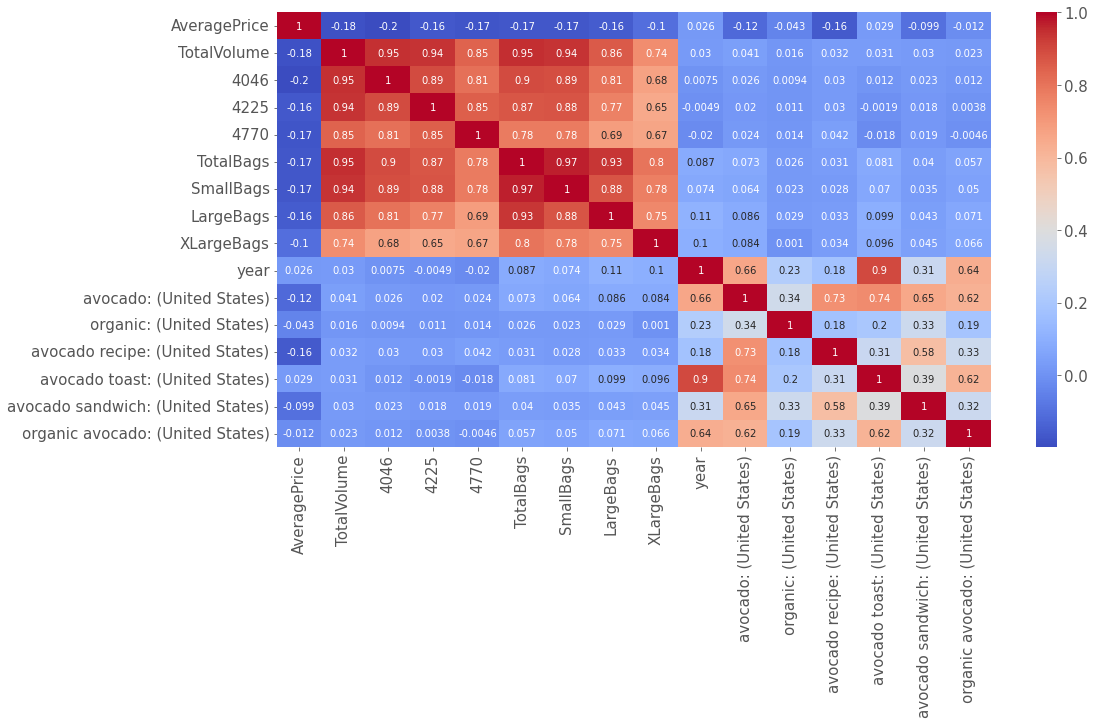

In [54]:
plt.figure(figsize=(16,8))
sns.heatmap(combined_df.corr(), cmap='coolwarm', annot=True)

### One hot encoding

In [55]:
cols = ['type', 'region']
combined_df[cols] = combined_df[cols].astype('category')
onehot_df = pd.get_dummies(combined_df, drop_first=True, columns=cols)
onehot_df.columns

Index(['Date', 'AveragePrice', 'TotalVolume', '4046', '4225', '4770',
       'TotalBags', 'SmallBags', 'LargeBags', 'XLargeBags', 'year', 'Week',
       'avocado: (United States)', 'organic: (United States)',
       'avocado recipe: (United States)', 'avocado toast: (United States)',
       'avocado sandwich: (United States)', 'organic avocado: (United States)',
       'type_organic', 'region_Atlanta', 'region_BaltimoreWashington',
       'region_Boise', 'region_Boston', 'region_BuffaloRochester',
       'region_California', 'region_Charlotte', 'region_Chicago',
       'region_CincinnatiDayton', 'region_Columbus', 'region_DallasFtWorth',
       'region_Denver', 'region_Detroit', 'region_GrandRapids',
       'region_GreatLakes', 'region_HarrisburgScranton',
       'region_HartfordSpringfield', 'region_Houston', 'region_Indianapolis',
       'region_Jacksonville', 'region_LasVegas', 'region_LosAngeles',
       'region_Louisville', 'region_MiamiFtLauderdale', 'region_Midsouth',
       're

In [56]:
onehot_df.head(20)

,Date,AveragePrice,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,...,region_SouthCarolina,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico
0,2015-01-04,1.220000,40873.28,2.819500e+03,28287.42,49.900000,9716.460000,9186.93000,529.530000,0.00000,...,0,0,0,0,0,0,0,0,0,0
1,2015-01-04,1.000000,435021.49,3.643024e+05,23821.16,82.150000,46815.790000,16707.15000,30108.640000,0.00000,...,0,0,0,0,0,0,0,0,0,0
2,2015-01-04,1.307835,788025.06,5.398731e+04,552906.04,39995.030000,141136.680000,137146.07000,3990.610000,0.00000,...,0,0,0,0,0,0,0,0,0,0
3,2015-01-04,1.010000,80034.32,4.456212e+04,24964.23,2752.350000,7755.620000,6064.30000,1691.320000,0.00000,...,0,0,0,0,0,0,0,0,0,0
4,2015-01-04,1.020000,491738.00,7.193870e+03,396752.18,128.820000,87663.130000,87406.84000,256.290000,0.00000,...,0,0,0,0,0,0,0,0,0,0
5,2015-01-04,1.400000,116253.44,3.267970e+03,55693.04,109.550000,57182.880000,57182.88000,0.000000,0.00000,...,0,0,0,0,0,0,0,0,0,0
6,2015-01-04,0.930000,5777334.90,2.843648e+06,2267755.26,137479.640000,528451.740000,477193.38000,47882.560000,3375.80000,...,0,0,0,0,0,0,0,0,0,0
7,2015-01-04,1.190000,166006.29,2.941903e+04,47220.75,38568.950000,50797.560000,93624.19466,24117.389216,0.00000,...,0,0,0,0,0,0,0,0,0,0
8,2015-01-04,1.110000,783068.03,3.027026e+04,550752.19,124506.100000,77539.480000,72888.46000,4651.020000,0.00000,...,0,0,0,0,0,0,0,0,0,0
9,2015-01-04,0.880000,228569.58,3.274300e+03,168764.78,1447.060000,119075.949904,17525.31000,37445.460000,112.67000,...,0,0,0,0,0,0,0,0,0,0


### PCA

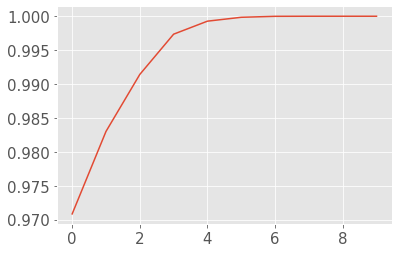

In [57]:
X = onehot_df.drop(['Date', 'AveragePrice', 'Week'], axis=1)
pca = PCA(n_components=10)
pca.fit_transform(X)

var = pca.explained_variance_ratio_
cumsum_var = np.cumsum(var)
plt.plot(cumsum_var)

3-4 PCs accounts nearly 99.5% of the variance

### Train test split

In [58]:
def train_test_avocado(input_df, test_size=0.3, random_state=42, pca_component_keep=None, min_max_scaling=False):
    X = input_df.drop(['Date', 'AveragePrice', 'Week'], axis=1)
    y = input_df['AveragePrice']
    
    if pca_component_keep:
        pca = PCA(n_components = pca_component_keep)
        X = pca.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    if min_max_scaling:
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
    print('Training shape: ', X_train.shape)
    print('Testing shape: ', X_test.shape)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_avocado(onehot_df, test_size=0.3, random_state=42, pca_component_keep=None, min_max_scaling=True)

Training shape:  (17537, 69)
Testing shape:  (7516, 69)


### Plot price distribution between train/test split

Text(0.5, 1.0, 'Price distributions between train/test set')

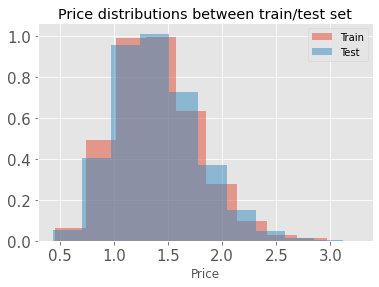

In [59]:

y_train.hist(alpha=0.5, density=True)
y_test.hist(alpha=0.5, density=True)
plt.legend(['Train', 'Test'])
plt.xlabel('Price')
plt.title('Price distributions between train/test set')

## Modelling

### Linear Regression

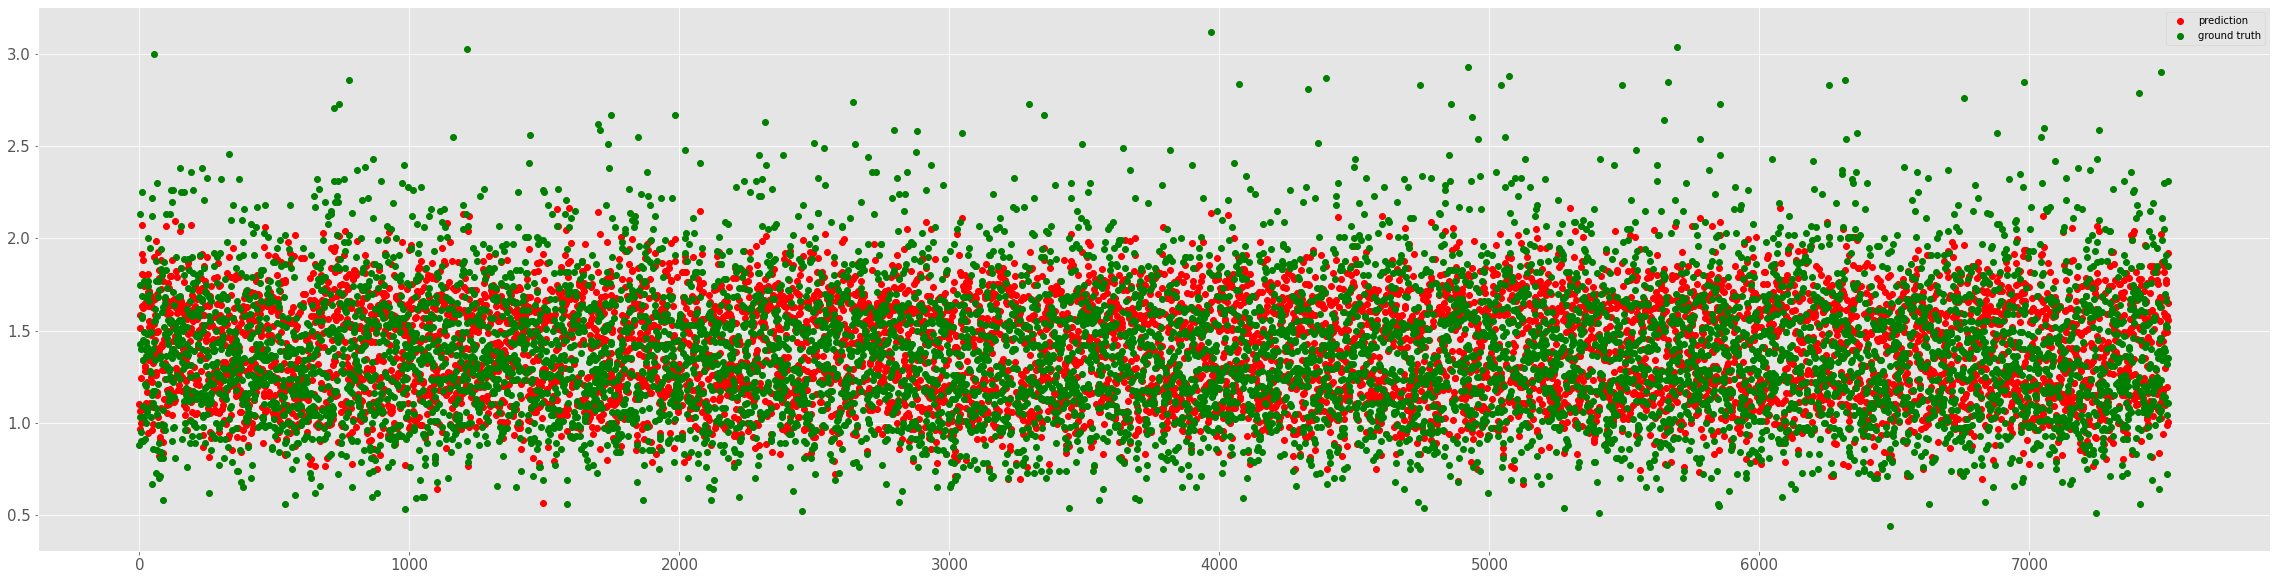


 Linear Regression:
r2:  0.5519
MAE:  0.1924
MSE:  0.0642


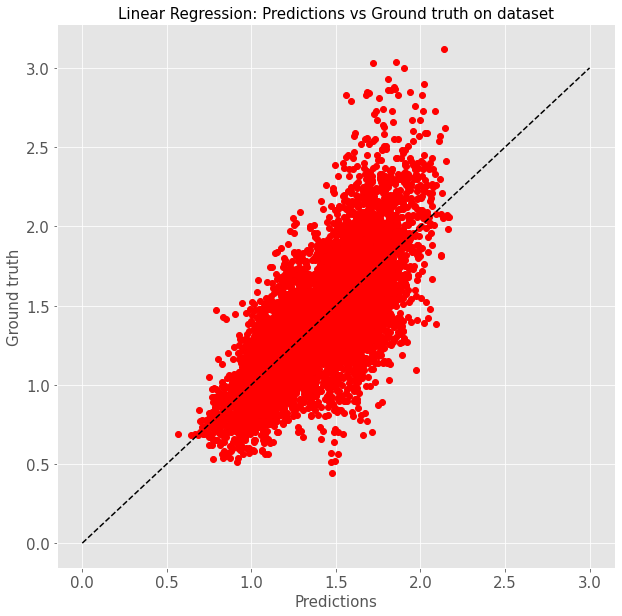

In [60]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_predicted = lr.predict(X_test)
result_plot(y_test.values, y_predicted, 'Linear Regression')

### Decison Tree

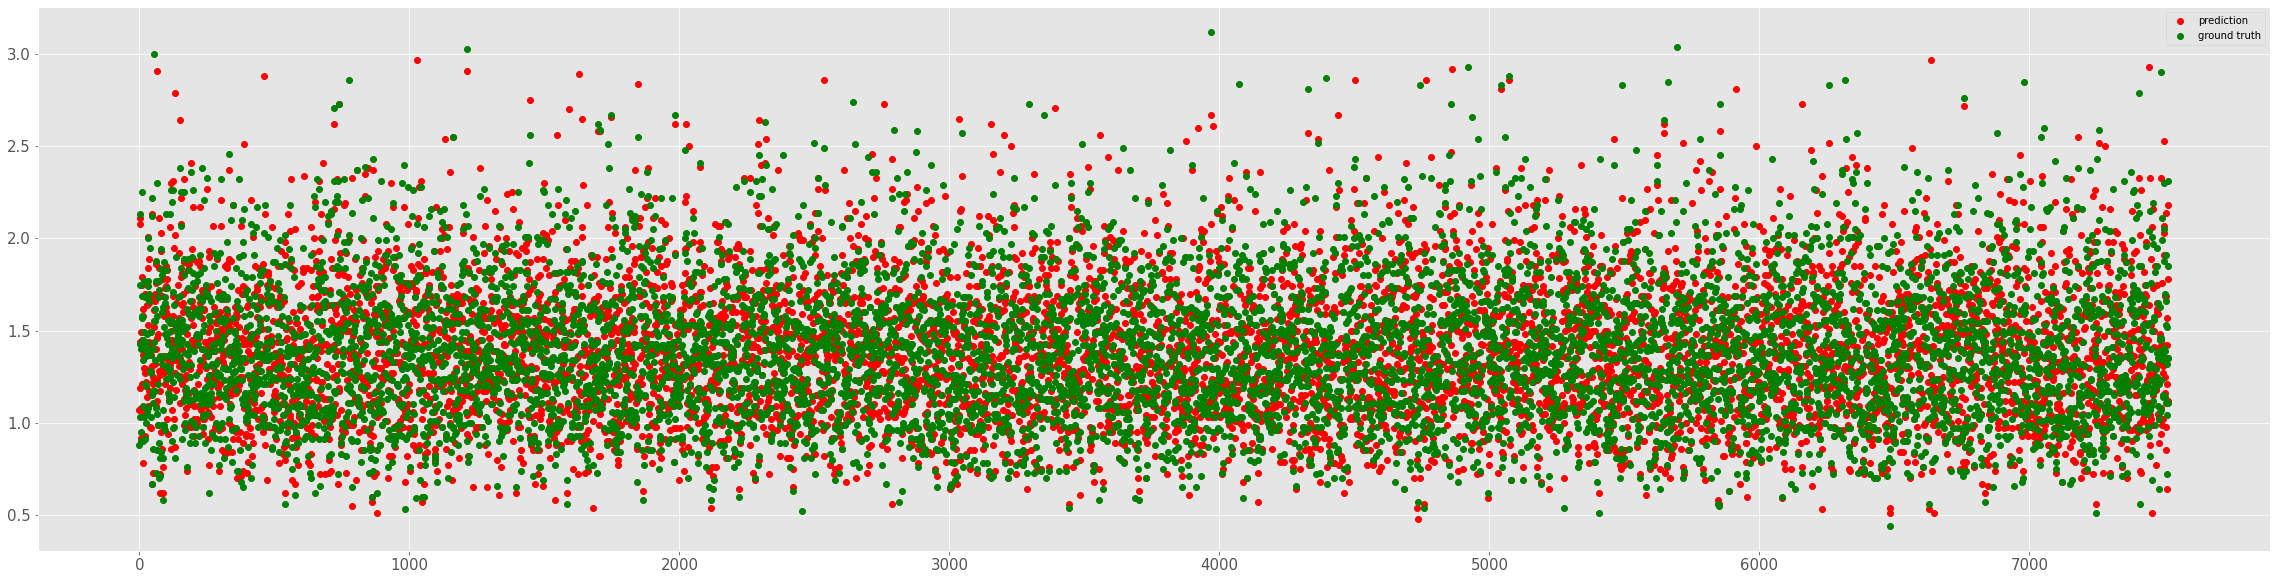


 Decision Tree:
r2:  0.5835
MAE:  0.1652
MSE:  0.0597


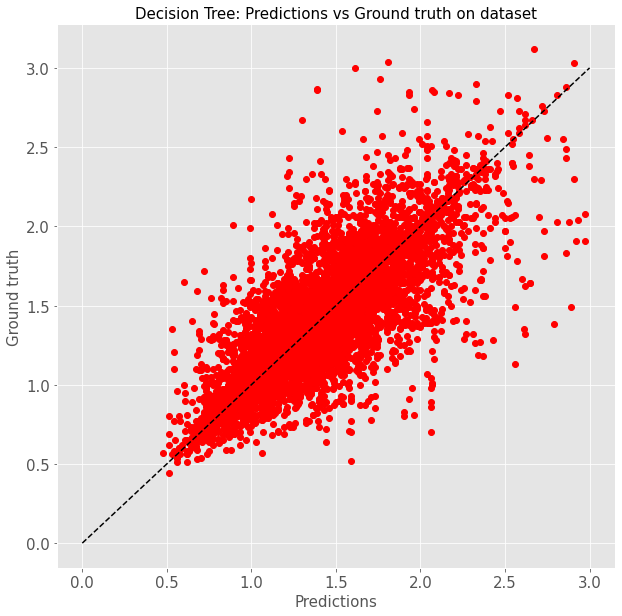

In [61]:
from sklearn.tree import DecisionTreeRegressor
dctr = DecisionTreeRegressor()
dctr.fit(X_train, y_train)
y_predicted = dctr.predict(X_test)
result_plot(y_test.values, y_predicted, 'Decision Tree')

### XGBoost Regressor

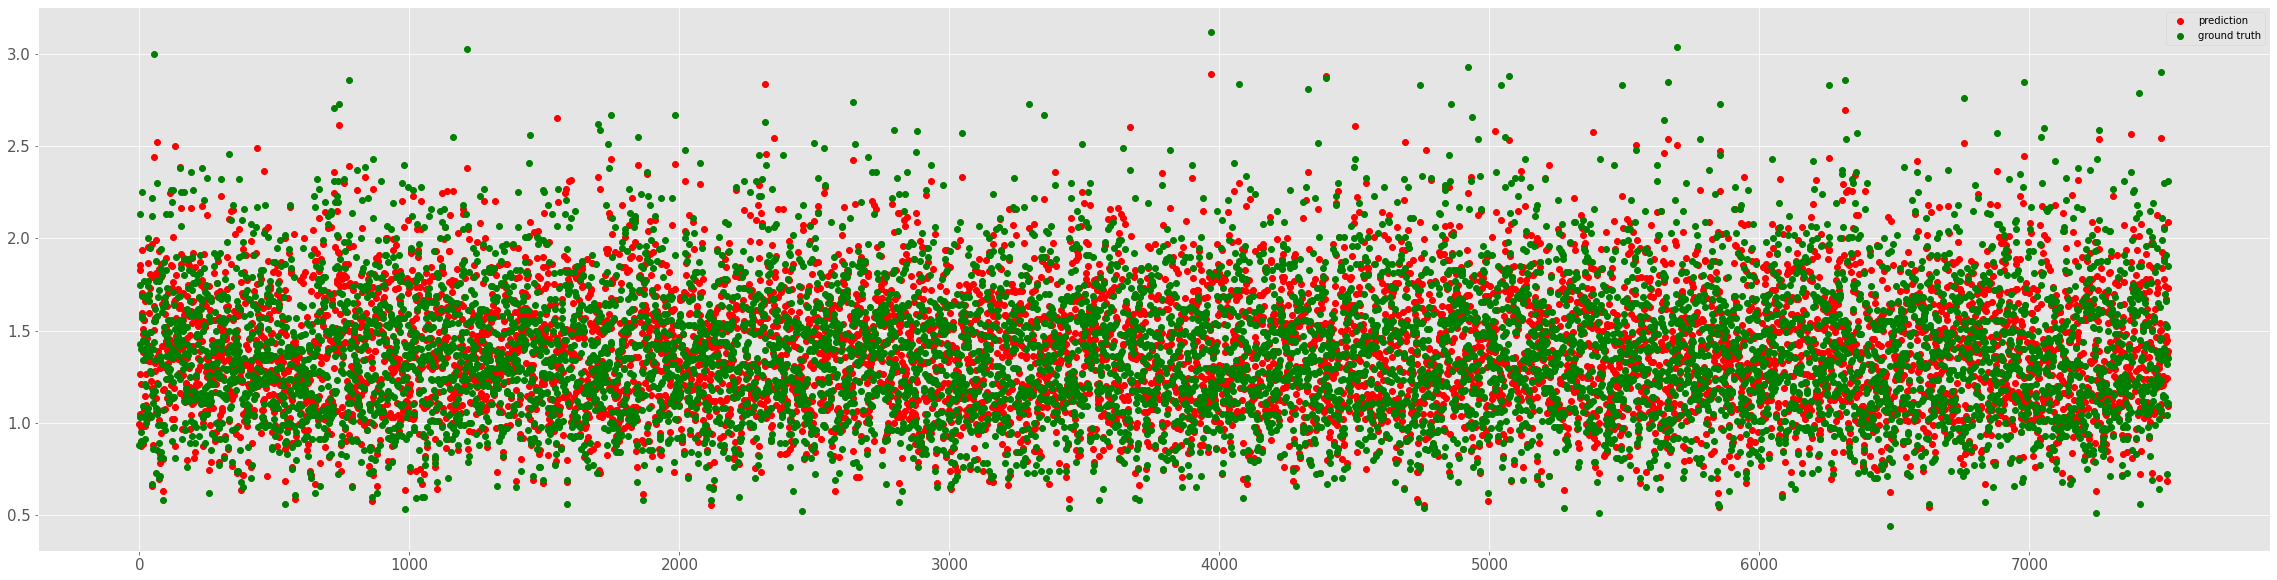


 XGBoost Regressor:
r2:  0.831
MAE:  0.111
MSE:  0.0242


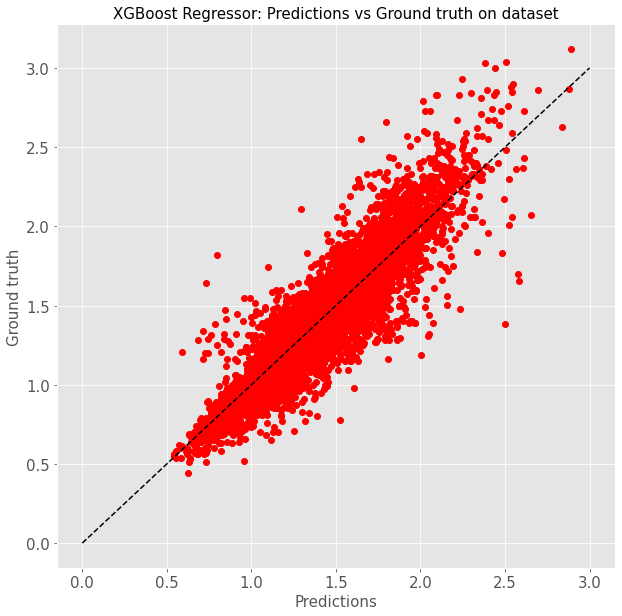

In [62]:
xgbr = xgboost.XGBRegressor()
xgbr.fit(X_train, y_train)
y_predicted = xgbr.predict(X_test)
result_plot(y_test.values, y_predicted, 'XGBoost Regressor')

<AxesSubplot:title={'center':'Feature importance'}>

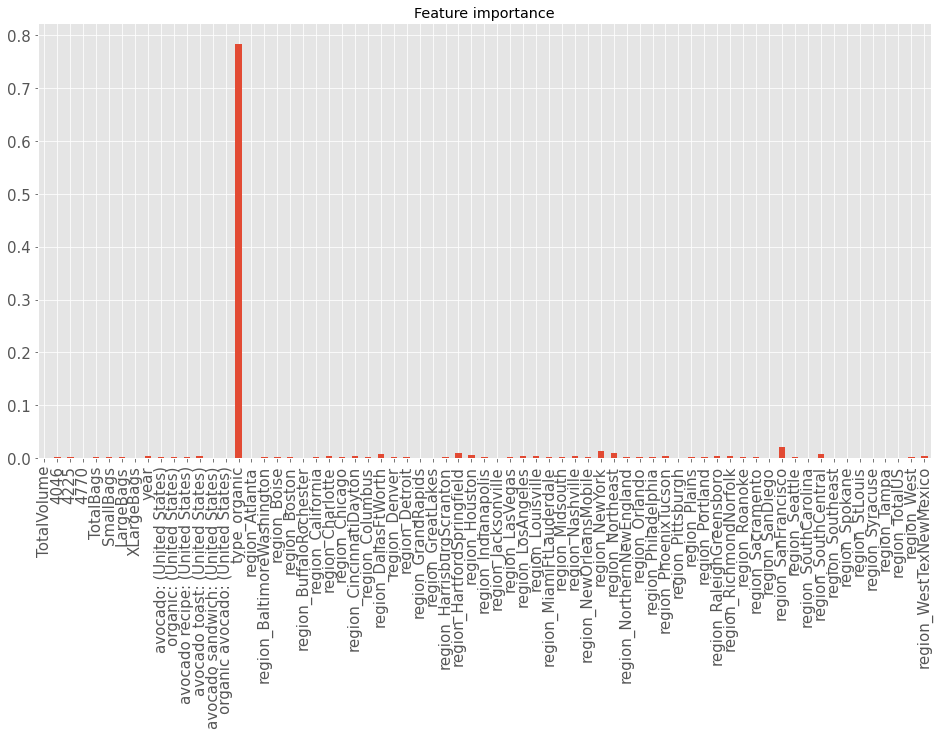

In [63]:
# Plot feature importance but only PCA is not applied
dic = {}
for (col, score) in zip(X.columns, xgbr.feature_importances_):
    dic[col] = [score]

ft_imp = pd.DataFrame.from_dict(dic)
ft_imp.iloc[0].plot(kind='bar', figsize=(16,8), title='Feature importance')

### Dense ANN modeling

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               7000      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 37,401
Trainable params: 37,401
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
549/549 [==============================] - 0s 837us/step - loss: 0.1273 - mse: 0.1273 - mae: 0.2727 - 

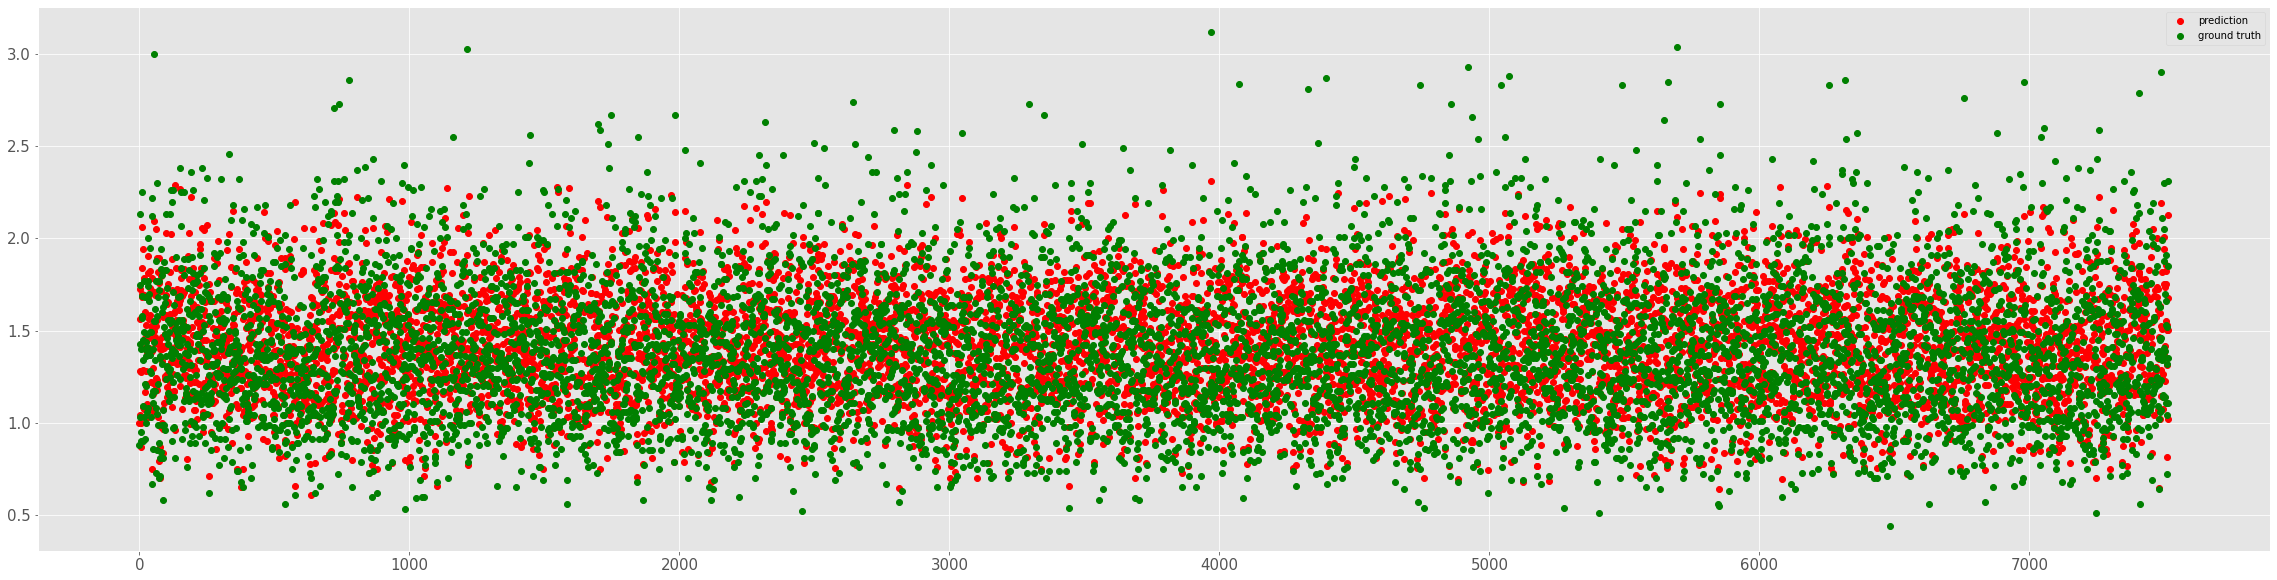


 Dense ANN:
r2:  0.6324
MAE:  0.1723
MSE:  0.0527


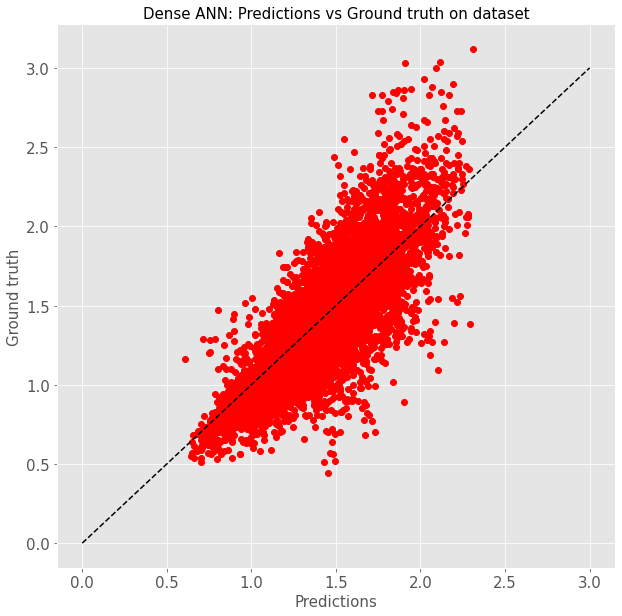

In [64]:
from tensorflow.keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon())) 

def build_model(train_shape, optimizer='Adam', num_layers=1, num_perceptrons=10, activation='sigmoid'):
    model = Sequential()
    model.add(Input(shape=train_shape))
    for i in range(num_layers):
        model.add(Dense(num_perceptrons, activation=activation))
    model.add(Dense(1, activation='linear'))

    print(model.summary())
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mae', coeff_determination])
    return model

model = build_model(X_train.shape[1], num_layers=4, num_perceptrons=100)

history = model.fit(X_train, y_train, batch_size=32, epochs=50)

y_predicted = model.predict(X_test)
result_plot(y_test.values, y_predicted, 'Dense ANN')